In [28]:
import os
import requests
import pandas as pd
import json
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.stats import linregress
import scipy.stats as st

In [29]:
# Reading in necessary csv files
house_valuesdf = pd.read_csv('resources/income_vs_home_rent.csv')
df_2019 = pd.read_csv("resources/Clean_2019.csv")
df_2020 = pd.read_csv("resources/income_vs_home_rent.csv")  
df_2021 = pd.read_csv("resources/Clean_2021.csv")
df_2022 = pd.read_csv("resources/Clean_2022.csv")
df_2023 = pd.read_csv("resources/Clean_2023.csv")
df_cleaned = pd.read_csv("resources/Final.csv")
merged_df = pd.read_csv('resources/calc.csv')

In [30]:
# Isoalte the County, Year, and Median Home Value columns in the house_valuesdf
housevaluecols = ['County','Year','Median Home Value']
median_homevalsdf = house_valuesdf[housevaluecols].dropna()

# Define columns to keep in each of the Clean_2019-2023 dataframes
columns_to_keep = {
    "df_2019": ["Geographic Area Name", "Median (dollars)"],
    "df_2020": ["County", "Median Gross Rent"],
    "df_2021": ["Geographic Area Name", "Median (dollars)"],
    "df_2022": ["Geographic Area Name", "Median (dollars)"],
    "df_2023": ["Geographic Area Name", "Median (dollars)"]
}

# Normalize column names to avoid mismatches in the df_cleaned dataframe
df_cleaned.columns = df_cleaned.columns.str.strip()  
df_cleaned.columns = df_cleaned.columns.str.lower() 
df_cleaned.columns = df_cleaned.columns.str.strip().str.lower()  # Remove leading/trailing spaces and convert to lowercase
df_cleaned = df_cleaned.rename(columns={'county subdivision': 'subdivision'})
df_cleaned["subdivision"] = df_cleaned["subdivision"].str.replace(" CCD", "", regex=False).str.replace(" County", "", regex=False)


# Median house value information


In [31]:
# Created separate dataframes to be able to plot a line for each county from the median_homevalsdf
Clackamas_df= median_homevalsdf[median_homevalsdf['County'] == 'Clackamas County, Oregon']
Multnomah_df= median_homevalsdf[median_homevalsdf['County']== 'Multnomah County, Oregon']
Washington_df = median_homevalsdf[median_homevalsdf['County']== 'Washington County, Oregon']

C:\Users\moreb\AppData\Local\Temp\ipykernel_20756\163065864.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





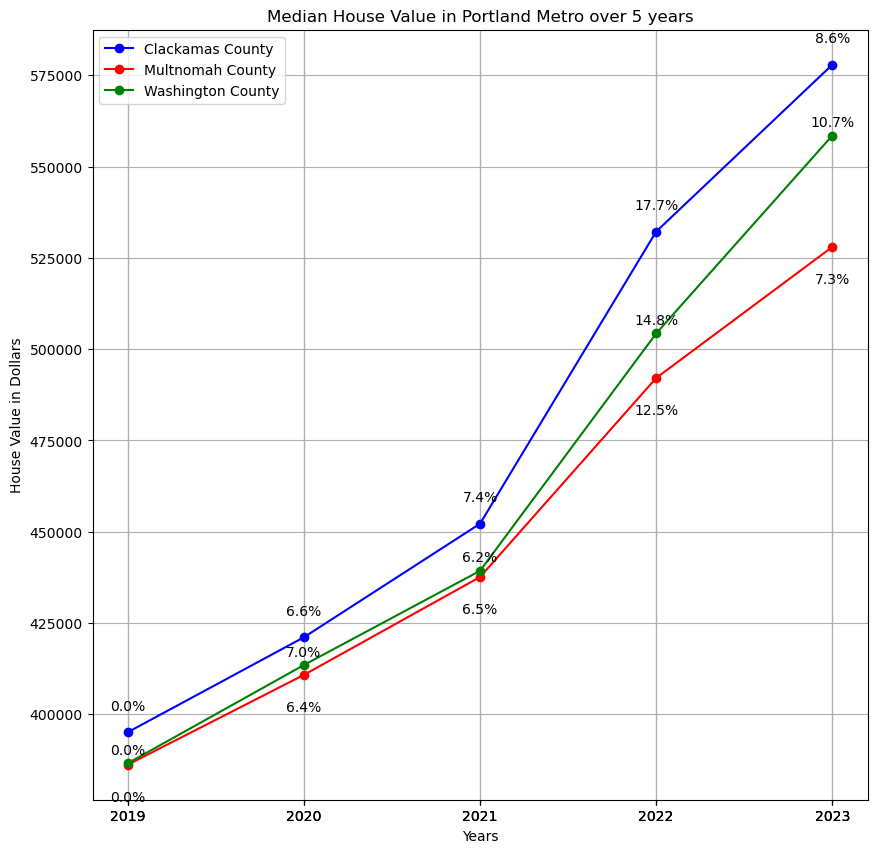

In [32]:
# Plotting Line Graph showing Median Home Value changes in Clackamas.

plt.figure(figsize=(10,10))

Clackamas_line, = plt.plot(Clackamas_df['Year'],Clackamas_df['Median Home Value'], color = 'blue', label='Clackamas County', marker='o')
Multnomah_line, = plt.plot(Multnomah_df['Year'],Multnomah_df['Median Home Value'], color='red', label='Multnomah County', marker='o')
Washington_line, = plt.plot(Washington_df['Year'],Washington_df['Median Home Value'], color='green', label='Washington County', marker='o')


# Including YoY % Increase
median_homevalsdf = median_homevalsdf.sort_values(by=["County", "Year"]) # Ensure Df is sortd before calculating percent change
median_homevalsdf["YoY % Change"] = median_homevalsdf.groupby("County")["Median Home Value"].pct_change() * 100  # Establishing the YoY calculation
median_homevalsdf["YoY % Change"].fillna(0, inplace=True)  # Dropping NaN value
# 
offests = {
    "Multnomah County, Oregon": -10000,
    "Washington County, Oregon":2500,
    "Clackamas County, Oregon": 6000
}
for County in median_homevalsdf["County"].unique():
    subset = median_homevalsdf[median_homevalsdf["County"] == County]
    plt.gca().set_xticks(median_homevalsdf['Year'])
    plt.grid()
    # Add % change labels above each marker (Fixed: Use `pct`)
    for x, y, pct in zip(subset["Year"], subset["Median Home Value"], subset["YoY % Change"]):
        plt.text(x, y + offests[County], f"{pct:.1f}%", fontsize=10, ha="center")  # Corrected to use `pct`
# Removing decimal places from xticks so they increment by 1 each year.
plt.xlabel("Years")
plt.ylabel("House Value in Dollars")
plt.gca().set_xticks(median_homevalsdf['Year'])

plt.grid(True)
plt.title("Median House Value in Portland Metro over 5 years")
plt.legend(handles=[Clackamas_line, Multnomah_line,Washington_line])
plt.savefig('images/Median_Home_Values.png')
plt.show()

# Median rent information


In [33]:
# To specify only 2020 data from income_vs_home.csv
df_2020 = df_2020[df_2020["Year"] == 2020].copy()

# Filter each DataFrame (.copy is needed to create a copy of the new columns to keep, which then allows renaming)
df_2019 = df_2019[columns_to_keep["df_2019"]].copy()
df_2020 = df_2020[columns_to_keep["df_2020"]].copy()
df_2021 = df_2021[columns_to_keep["df_2021"]].copy()
df_2022 = df_2022[columns_to_keep["df_2022"]].copy()
df_2023 = df_2023[columns_to_keep["df_2023"]].copy()

# Standardize Column Names
rename_columns = {
    "Geographic Area Name": "County",
    "County": "County",
    "Median (dollars)": "Median Rent",
    "Median Gross Rent": "Median Rent"
}

#Applying the rename
df_2019.rename(columns=rename_columns, inplace=True)
df_2020.rename(columns=rename_columns, inplace=True)
df_2021.rename(columns=rename_columns, inplace=True)
df_2022.rename(columns=rename_columns, inplace=True)
df_2023.rename(columns=rename_columns, inplace=True)

# Assign a fixed "Year" value corresponding to the datasets. This will make graphing easier.

df_2019["Year"] = 2019
df_2020["Year"] = 2020
df_2021["Year"] = 2021
df_2022["Year"] = 2022
df_2023["Year"] = 2023

# Merge All Datasets into one DataFrame
# Using .conat() instead of .gropby() since it is better at merging entire datasets.
df_all = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023])

# Drop ", Oregon" from County Column
df_all["County"] = df_all["County"].str.replace(", Oregon", "", regex=False)

# Including YoY % Increase
df_all = df_all.sort_values(by=["County", "Year"]) # Ensure Df is sortd before calculating percent change

df_all["YoY % Change"] = df_all.groupby("County")["Median Rent"].pct_change() * 100  # Establishing the YoY calculation

df_all["YoY % Change"].fillna(0, inplace=True)  # Dropping NaN value


C:\Users\moreb\AppData\Local\Temp\ipykernel_20756\4105639456.py:46: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





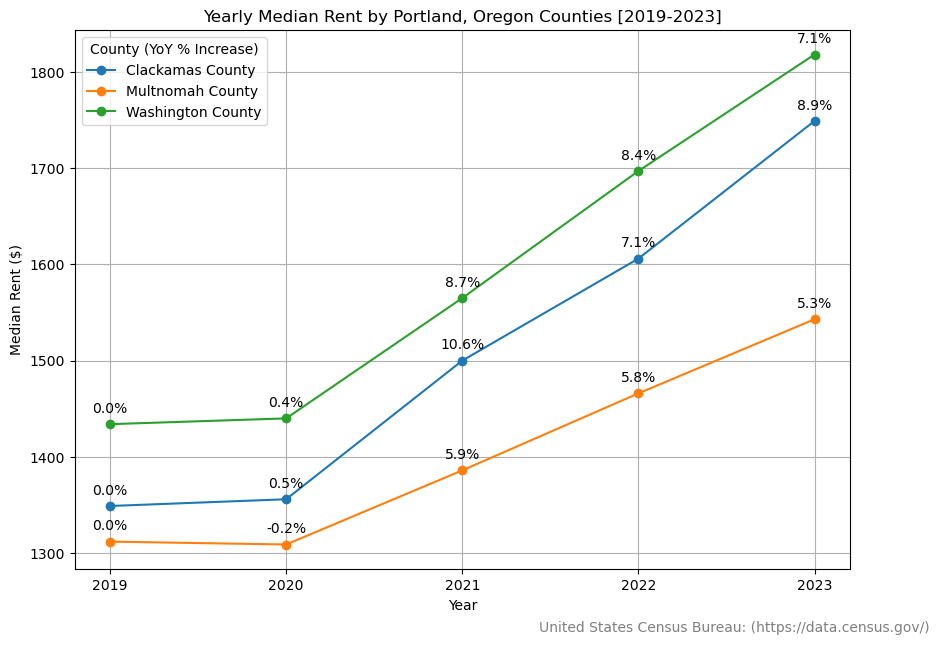

In [34]:
# Plotting The Line
plt.figure(figsize=(10,7))

for County in df_all["County"].unique(): 
    subset = df_all[df_all["County"] == County]
    plt.plot(subset["Year"], subset["Median Rent"], marker="o", linestyle="-", label=County)

    # Add % change labels above each marker (Fixed: Use `pct`)
    for x, y, pct in zip(subset["Year"], subset["Median Rent"], subset["YoY % Change"]):
        plt.text(x, y + 12, f"{pct:.1f}%", fontsize=10, ha="center")  # Corrected to use `pct`

# Customizations
plt.title("Yearly Median Rent by Portland, Oregon Counties [2019-2023]")
plt.xlabel("Year")
plt.ylabel("Median Rent ($)")
plt.legend(title="County (YoY % Increase)")
plt.grid(True)

# Raise the graph by a bit

# Citation
plt.figtext(0.98, 0.02, "United States Census Bureau: (https://data.census.gov/)", fontsize=10, ha="right", color="gray")

# Setting x-axis to whole year increments
plt.xticks(ticks=sorted(df_all["Year"].unique()), labels=sorted(df_all["Year"].unique()))

plt.savefig("images/median_rent_USCensus.png", dpi=300, bbox_inches="tight")

plt.show()

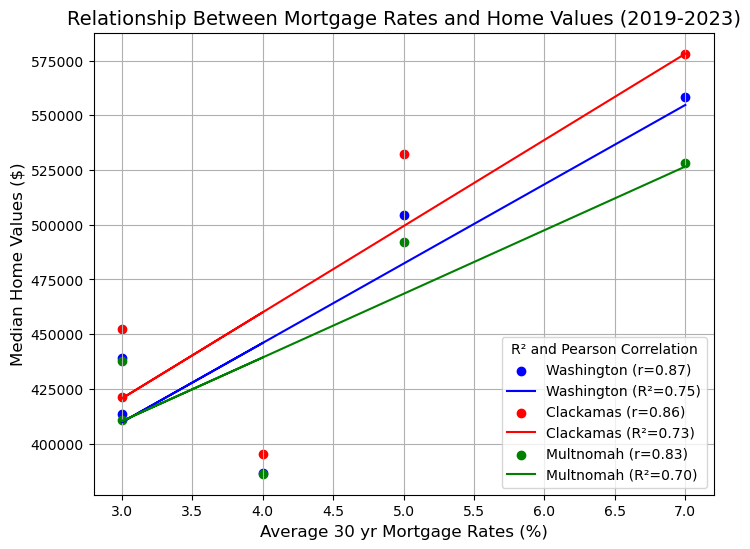

Washington County: R²=0.7497, Pearson Correlation=0.8659
Clackamas County: R²=0.7344, Pearson Correlation=0.8570
Multnomah County: R²=0.6963, Pearson Correlation=0.8344


In [35]:
# Function for Combined Linear Regression Plot
def plot_combined_regression(x_values, y_wash, y_clack, y_mult, xlabel):
    plt.figure(figsize=(8, 6))

    # Linear regression & Pearson correlation for Washington County
    slope_w, intercept_w, rvalue_w, pvalue_w, stderr_w = st.linregress(x_values, y_wash)
    correlation_w, _ = st.pearsonr(x_values, y_wash)
    regress_values_w = x_values * slope_w + intercept_w
    plt.scatter(x_values, y_wash, label=f"Washington (r={correlation_w:.2f})", color="blue")
    plt.plot(x_values, regress_values_w, "b-", label=f"Washington (R²={rvalue_w**2:.2f})")

    # Linear regression & Pearson correlation for Clackamas County
    slope_c, intercept_c, rvalue_c, pvalue_c, stderr_c = st.linregress(x_values, y_clack)
    correlation_c, _ = st.pearsonr(x_values, y_clack)
    regress_values_c = x_values * slope_c + intercept_c
    plt.scatter(x_values, y_clack, label=f"Clackamas (r={correlation_c:.2f})", color="red")
    plt.plot(x_values, regress_values_c, "r-", label=f"Clackamas (R²={rvalue_c**2:.2f})")

    # Linear regression & Pearson correlation for Multnomah County
    slope_m, intercept_m, rvalue_m, pvalue_m, stderr_m = st.linregress(x_values, y_mult)
    correlation_m, _ = st.pearsonr(x_values, y_mult)
    regress_values_m = x_values * slope_m + intercept_m
    plt.scatter(x_values, y_mult, label=f"Multnomah (r={correlation_m:.2f})", color="green")
    plt.plot(x_values, regress_values_m, "g-", label=f"Multnomah (R²={rvalue_m**2:.2f})")

    # Labels, Title, and Legend
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Median Home Values ($)", fontsize=12)
    plt.title(f"Relationship Between Mortgage Rates and Home Values (2019-2023)", fontsize=14)
    plt.legend(title="R² and Pearson Correlation", loc='lower right', fontsize=10)
    plt.grid(True)
    plt.savefig("images/Rates_v_Values", dpi=500)
    plt.show()

    # Print Pearson Correlation & R² Values
    print(f"Washington County: R²={rvalue_w**2:.4f}, Pearson Correlation={correlation_w:.4f}")
    print(f"Clackamas County: R²={rvalue_c**2:.4f}, Pearson Correlation={correlation_c:.4f}")
    print(f"Multnomah County: R²={rvalue_m**2:.4f}, Pearson Correlation={correlation_m:.4f}")

# Define x and y variables
x_values = merged_df['Average Rate']  # X-axis variable (Mortgage Rates)
w_homes = merged_df['Washington County: Median Home Values']
c_homes = merged_df['Clackamas County: Median Home Values']
m_homes = merged_df['Multnomah County: Median Home Values']

# Plot all counties on one graph
plot_combined_regression(x_values, w_homes, c_homes, m_homes, "Average 30 yr Mortgage Rates (%)")


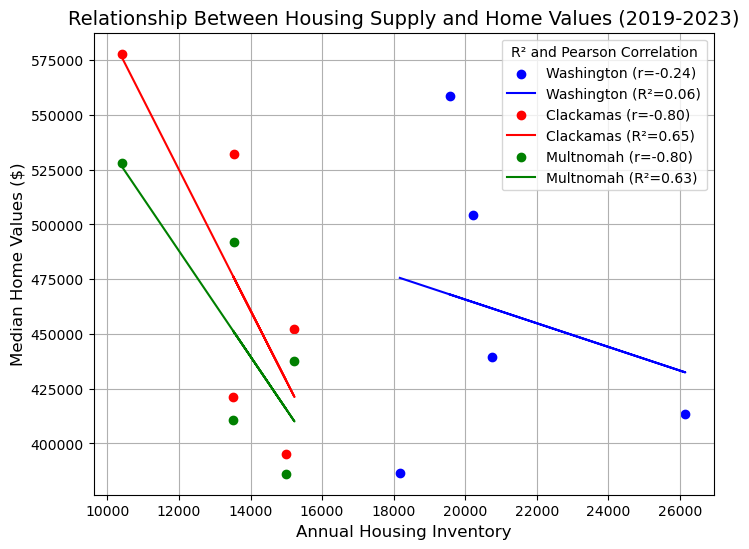

Washington County: R²=0.0554, Pearson Correlation=-0.2353
Clackamas County: R²=0.6456, Pearson Correlation=-0.8035
Multnomah County: R²=0.6323, Pearson Correlation=-0.7952


In [36]:
# Function for Combined Linear Regression Plot with Pearson Correlation
def plot_combined_regression(x_wash, x_clack, x_mult, y_wash, y_clack, y_mult, xlabel):
    plt.figure(figsize=(8, 6))

    # Linear regression & Pearson correlation for Washington County
    slope_w, intercept_w, rvalue_w, pvalue_w, stderr_w = st.linregress(x_wash, y_wash)
    correlation_w, _ = st.pearsonr(x_wash, y_wash)
    regress_values_w = x_wash * slope_w + intercept_w
    plt.scatter(x_wash, y_wash, label=f"Washington (r={correlation_w:.2f})", color="blue")
    plt.plot(x_wash, regress_values_w, "b-", label=f"Washington (R²={rvalue_w**2:.2f})")

    # Linear regression & Pearson correlation for Clackamas County
    slope_c, intercept_c, rvalue_c, pvalue_c, stderr_c = st.linregress(x_clack, y_clack)
    correlation_c, _ = st.pearsonr(x_clack, y_clack)
    regress_values_c = x_clack * slope_c + intercept_c
    plt.scatter(x_clack, y_clack, label=f"Clackamas (r={correlation_c:.2f})", color="red")
    plt.plot(x_clack, regress_values_c, "r-", label=f"Clackamas (R²={rvalue_c**2:.2f})")

    # Linear regression & Pearson correlation for Multnomah County
    slope_m, intercept_m, rvalue_m, pvalue_m, stderr_m = st.linregress(x_mult, y_mult)
    correlation_m, _ = st.pearsonr(x_mult, y_mult)
    regress_values_m = x_mult * slope_m + intercept_m
    plt.scatter(x_mult, y_mult, label=f"Multnomah (r={correlation_m:.2f})", color="green")
    plt.plot(x_mult, regress_values_m, "g-", label=f"Multnomah (R²={rvalue_m**2:.2f})")

    # Labels, Title, and Legend
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Median Home Values ($)", fontsize=12)
    plt.title(f"Relationship Between Housing Supply and Home Values (2019-2023)", fontsize=14)
    plt.grid(True)
    plt.legend(title="R² and Pearson Correlation", loc='upper right', fontsize=10)
    plt.savefig('images/Supply_V_Values')
    plt.show()

    # Print Pearson Correlation & R² Values
    print(f"Washington County: R²={rvalue_w**2:.4f}, Pearson Correlation={correlation_w:.4f}")
    print(f"Clackamas County: R²={rvalue_c**2:.4f}, Pearson Correlation={correlation_c:.4f}")
    print(f"Multnomah County: R²={rvalue_m**2:.4f}, Pearson Correlation={correlation_m:.4f}")

# y variables
w_homes = merged_df['Washington County: Median Home Values']
c_homes = merged_df['Clackamas County: Median Home Values']
m_homes = merged_df['Multnomah County: Median Home Values']

# X-axis variables (Houses for Sale)
w_house_count = merged_df['Washington County: Annual Housing Supply']
c_house_count = merged_df['Clackamas County: Annual Housing Supply']
m_house_count = merged_df['Multnomah County: Annual Housing Supply']

# Plot all counties on one graph with Pearson correlation
plot_combined_regression(w_house_count, c_house_count, m_house_count, w_homes, c_homes, m_homes, "Annual Housing Inventory")


# Affordability across county subdivisions

In [37]:

# Rename 'county subdivision' to 'subdivision' and clean the names
df_cleaned = df_cleaned.rename(columns={'county subdivision': 'subdivision'})
df_cleaned["subdivision"] = df_cleaned["subdivision"].str.replace(" CCD", "", regex=False).str.replace(" County", "", regex=False)

# Display the cleaned dataframe
df_cleaned


,subdivision,year,median household income,median home value,county,latitude,longitude
0,"Beavercreek, Clackamas, Oregon",2023,122212,660600,Clackamas,45.287929,-122.535342
1,"Beavercreek, Clackamas, Oregon",2022,114926,644600,Clackamas,45.287929,-122.535342
2,"Beavercreek, Clackamas, Oregon",2021,101283,522900,Clackamas,45.287929,-122.535342
3,"Beavercreek, Clackamas, Oregon",2020,99750,501200,Clackamas,45.287929,-122.535342
4,"Beavercreek, Clackamas, Oregon",2019,93279,468400,Clackamas,45.287929,-122.535342
...,...,...,...,...,...,...,...
110,"Yoder, Clackamas, Oregon",2023,109921,719800,Clackamas,45.138177,-122.681757
111,"Yoder, Clackamas, Oregon",2022,110688,673600,Clackamas,45.138177,-122.681757
112,"Yoder, Clackamas, Oregon",2021,96365,560200,Clackamas,45.138177,-122.681757
113,"Yoder, Clackamas, Oregon",2020,87969,517400,Clackamas,45.138177,-122.681757


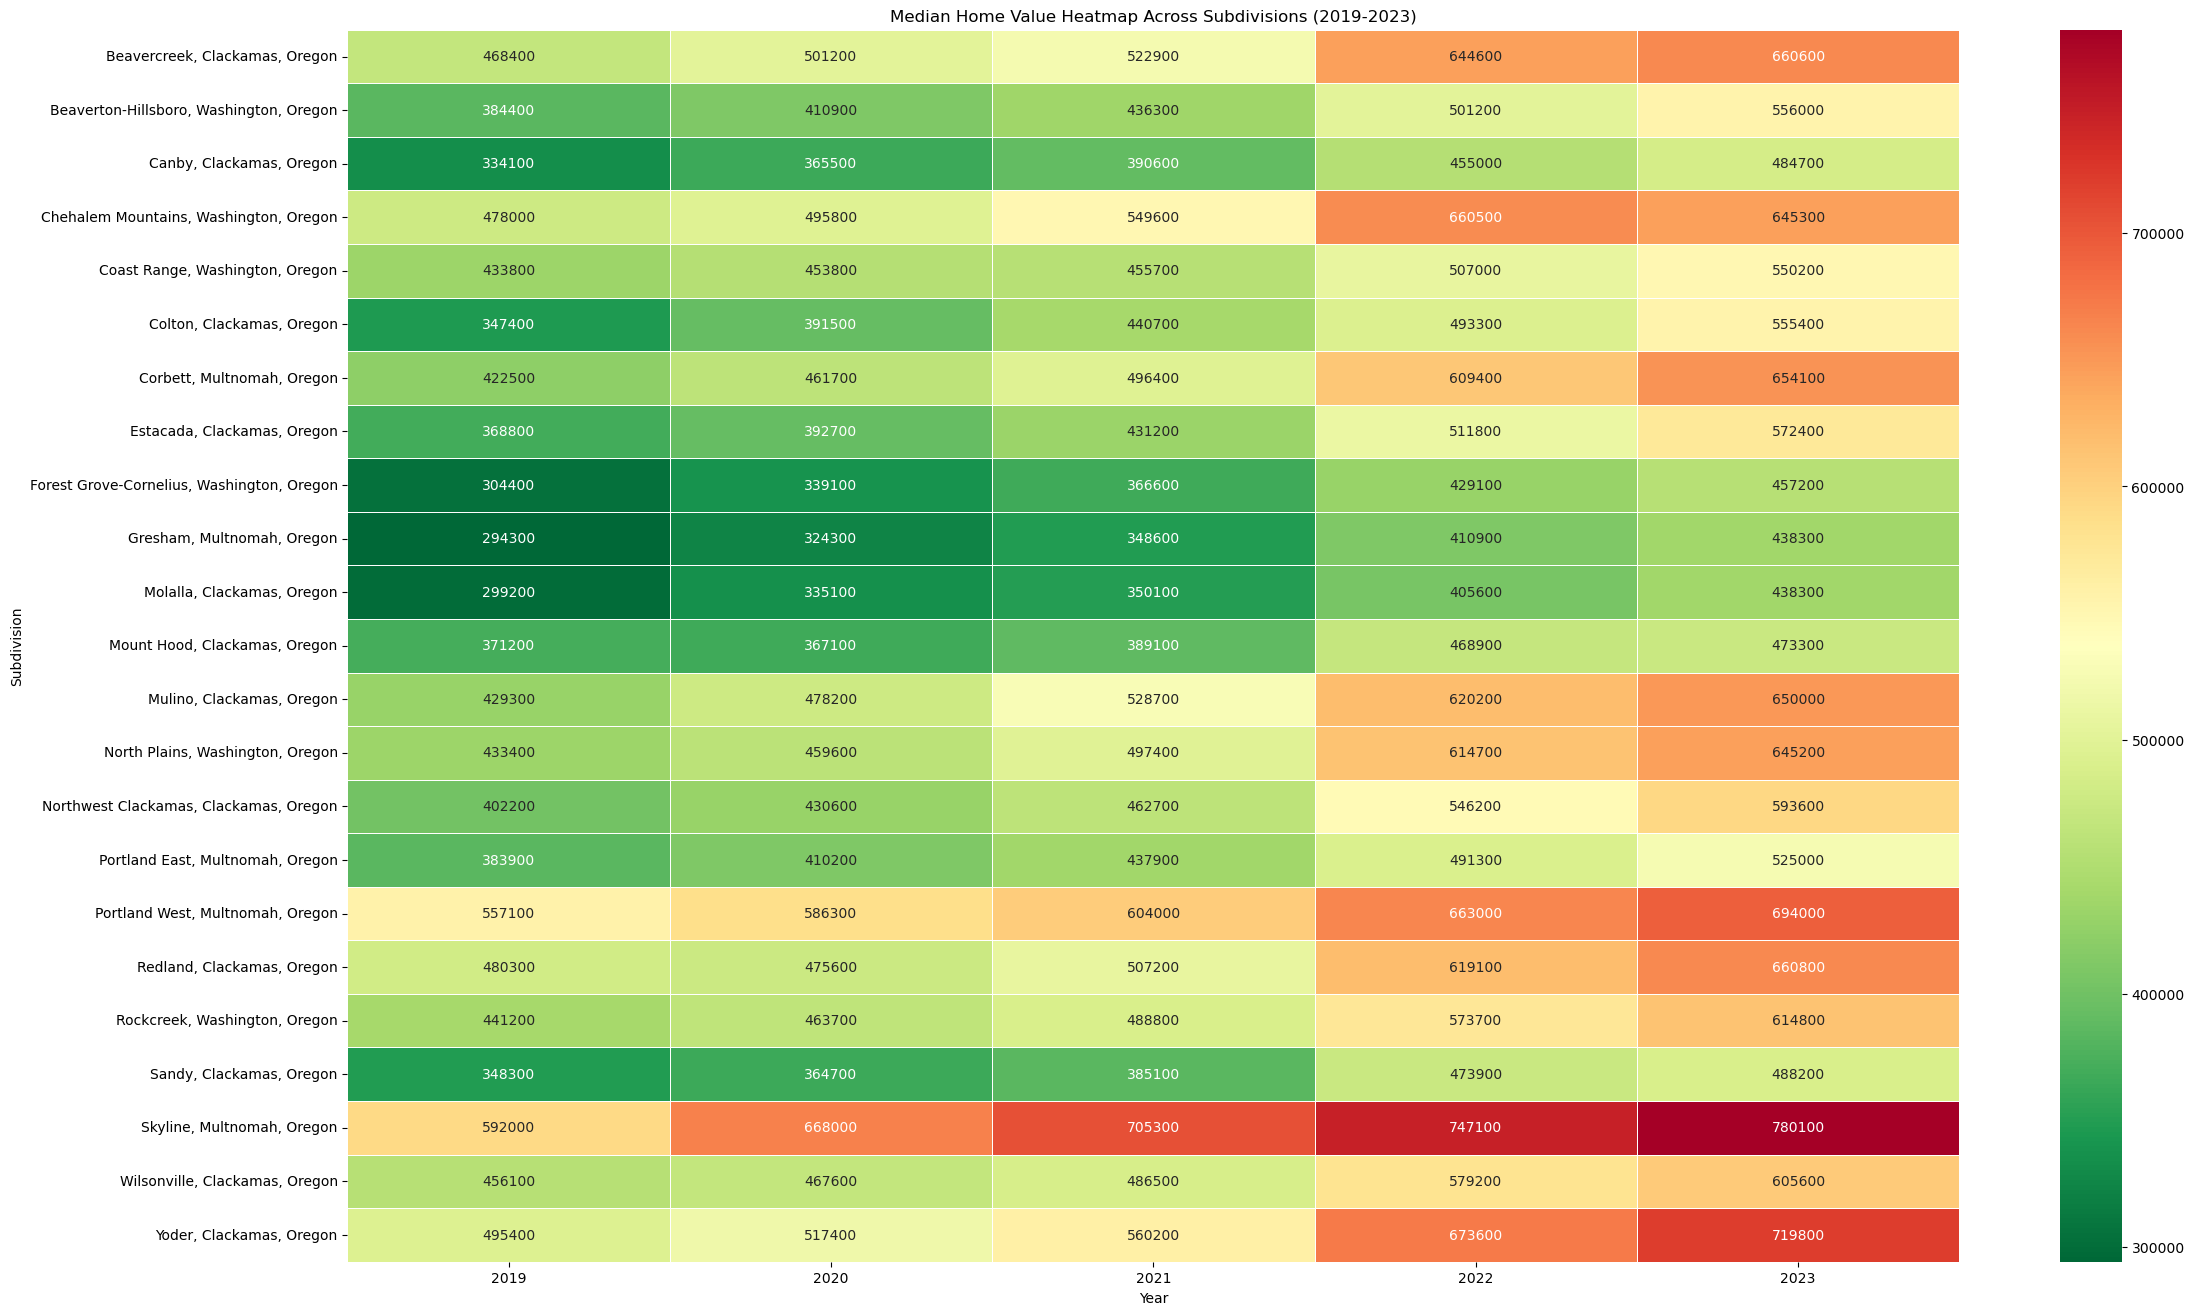

In [44]:
# Now create the wide format data for the heatmap
df_wide = df_cleaned.pivot(index='subdivision', columns='year', values='median home value')

# Create a heatmap for each subdivision with a red-to-green color scale
plt.figure(figsize=(26, 16))
sns.heatmap(
    df_wide, 
    annot=True, 
    fmt=".0f", 
    cmap="RdYlGn_r", 
    linewidths=0.5
)

# Customize the plot
plt.title("Median Home Value Heatmap Across Subdivisions (2019-2023)")
plt.xlabel("Year")
plt.ylabel("Subdivision")

# Show the heatmap
plt.savefig('images/Value_Heatmap')
plt.show()

In [39]:
# Ensure "Year" is numeric
df_cleaned["Year"] = pd.to_numeric(df_cleaned["year"], errors="coerce")

# Drop rows with missing latitude and longitude values
df_cleaned = df_cleaned.dropna(subset=["latitude", "longitude"])

# Calculate Home Value to Income Ratio
df_cleaned["Home Value to Income Ratio"] = df_cleaned["median home value"] / df_cleaned["median household income"]

# Define a custom color scale where values < 5 are light green, progressing to red
color_scale = [
    (0, "lightgreen"),  # affordable (Ratio < 5)
    (0.5, "yellow"),    # Medium affordability
    (1, "red")          # Least affordable (High Ratio)
]

# Normalize Home Value to Income Ratio for color mapping
df_cleaned["Normalized Ratio"] = np.clip(df_cleaned["Home Value to Income Ratio"] / 10, 0, 1)  # Scaling to [0,1]

# Create an interactive scatter map for Home Value to Income Ratio
fig = px.scatter_mapbox(
    df_cleaned,
    lat='latitude',
    lon='longitude',
    size="median home value",
    color="median home value",
    hover_name="subdivision",
    hover_data=["county", "median home value", "Year"],
    animation_frame="Year",
    mapbox_style="carto-positron",
    color_continuous_scale=color_scale,
    title="Median Home Values by Subdivisions (2019-2023)"
)

# Increase figure size
fig.update_layout(
    autosize=True,
    width=1200,
    height=800
)

# Show the interactive map
fig.show()


C:\Users\moreb\AppData\Local\Temp\ipykernel_20756\2847742895.py:21: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [40]:
# Load the cleaned dataset
df = pd.read_csv('resources/Final.csv')

# Calculate the Home Value to Household Income ratio
df["Home Value to Income Ratio"] = df["Median Home Value"] / df["Median Household Income"]

# Create a new DataFrame with selected columns
df_ratio = df[["County Subdivision", "Year", "Median Household Income", "Median Home Value", "Home Value to Income Ratio"]]

# Display the new DataFrame
df_ratio

,County Subdivision,Year,Median Household Income,Median Home Value,Home Value to Income Ratio
0,"Beavercreek CCD, Clackamas County, Oregon",2023,122212,660600,5.405361
1,"Beavercreek CCD, Clackamas County, Oregon",2022,114926,644600,5.608827
2,"Beavercreek CCD, Clackamas County, Oregon",2021,101283,522900,5.162762
3,"Beavercreek CCD, Clackamas County, Oregon",2020,99750,501200,5.024561
4,"Beavercreek CCD, Clackamas County, Oregon",2019,93279,468400,5.021495
...,...,...,...,...,...
110,"Yoder CCD, Clackamas County, Oregon",2023,109921,719800,6.548339
111,"Yoder CCD, Clackamas County, Oregon",2022,110688,673600,6.085574
112,"Yoder CCD, Clackamas County, Oregon",2021,96365,560200,5.813314
113,"Yoder CCD, Clackamas County, Oregon",2020,87969,517400,5.881617


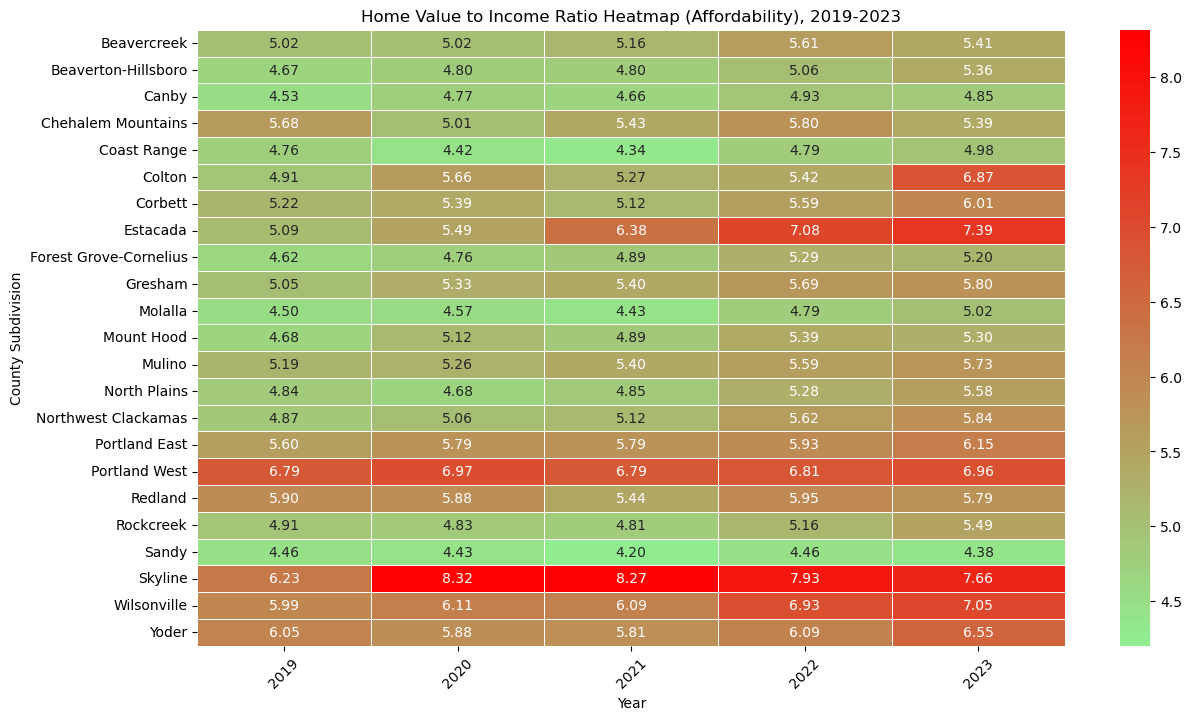

In [41]:
# Calculate the Home Value to Household Income ratio
df["Home Value to Income Ratio"] = df["Median Home Value"] / df["Median Household Income"]

# Function to clean the County Subdivision names
def clean_subdivision_name(name):
    return name.split(",")[0].replace(" CCD", "").strip()

# Apply the function to clean the names
df["County Subdivision"] = df["County Subdivision"].apply(clean_subdivision_name)

# Create a new DataFrame with selected columns
df_ratio = df[["County Subdivision", "Year", "Home Value to Income Ratio"]]

# Pivot the DataFrame for visualization
heatmap_data_cleaned = df_ratio.pivot(index="County Subdivision", columns="Year", values="Home Value to Income Ratio")

# Define a custom colormap: Light green for values < 5, red for values >= 5
colors = ["lightgreen", "red"]
cmap_custom = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

# Set up the figure
plt.figure(figsize=(14, 8))

# Create the heatmap with the custom colormap
sns.heatmap(heatmap_data_cleaned, cmap=cmap_custom, annot=True, fmt=".2f", linewidths=0.5)

# Set titles and labels

plt.title("Home Value to Income Ratio Heatmap (Affordability), 2019-2023")
plt.xlabel("Year")
plt.ylabel("County Subdivision")

# Show the heatmap
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig('images/Value_Income_heatmap')
plt.show()

In [42]:
# Define a custom color scale where values < 5 are light green, progressing to red
color_scale = [
    (0, "lightgreen"),  # affordable (Ratio < 5)
    (0.5, "yellow"),    # Medium affordability
    (1, "red")          # Least affordable (High Ratio)
]

# Normalize Home Value to Income Ratio for color mapping
df["Normalized Ratio"] = np.clip(df["Home Value to Income Ratio"] / 10, 0, 1)  # Scaling to [0,1]

# Create an interactive scatter map for Home Value to Income Ratio
fig = px.scatter_mapbox(
    df,
    lat='Latitude',
    lon='Longitude',
    size="Home Value to Income Ratio",
    color="Home Value to Income Ratio",
    hover_name="County Subdivision",
    hover_data=["County", "Home Value to Income Ratio", "Year"],
    animation_frame="Year",  # Include all years with animation
    mapbox_style="carto-positron",
    color_continuous_scale=color_scale,  # Custom color scale
    title="Home Value to Income Ratio by Subdivisions (2019-2023)"
)

# Increase figure size
fig.update_layout(
    autosize=True,
    width=1200,
    height=800
)

# Show the interactive map

fig.show()


C:\Users\moreb\AppData\Local\Temp\ipykernel_20756\3673908503.py:12: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

